# Bienestar en Bogotá - OPM
## Juan Diego Mayorga 
## MCPP
## 2022-1
-----

# FOOD 
¿Hay una correcta asignación de los puestos de comida al rededor de bogotá? En este código se hará un análisis de correlaciones con indicadores económicos de interés.

Este ejemplo es replicable con otros tipos de establecimientos como lo son centros educativos, salud y entre otros.

In [19]:
# Packages 

# OSM
#%pip install overpass
#%pip install OSMPythonTools]

import requests 
import overpass
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass

# Data 
import pandas as pd
import json
from datetime import datetime,timedelta
import time
import numpy 

# Text 
import re

# Graphs 
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Cargamos la base de datos
food = pd.read_excel("Data sets/OSM maps/Final/food ag.xlsx")
food

,Localidad,Amenity,Codigo Loc,Total
0,Antonio Nariño,bar,15,54
1,Antonio Nariño,cafe,15,50
2,Antonio Nariño,fast_food,15,38
3,Antonio Nariño,pub,15,2
4,Antonio Nariño,restaurant,15,88
...,...,...,...,...
82,Usaquén,restaurant,1,598
83,Usme,bar,5,4
84,Usme,cafe,5,6
85,Usme,fast_food,5,2


In [21]:
# agrupamos por localidad 
food_total = pd.DataFrame(food.groupby(['Localidad', "Codigo Loc"], as_index=False)["Total"].sum())
food_total.describe()
# tenemos una base de datos con el total de restaurantes por localidad

,Codigo Loc,Total
count,19.000000,19.000000
mean,10.000000,620.210526
std,5.627314,572.038419
min,1.000000,28.000000
25%,5.500000,192.000000
50%,10.000000,550.000000
75%,14.500000,829.000000
max,19.000000,2248.000000


In [22]:
# En conexión con tableur el nombre de la columna "Objectid" se cambió, por lo tanto, debemos vovler a cambiarlo.
food_total.rename(columns = {'Codigo Loc':'Objectid'}, inplace = True)
food_total

,Localidad,Objectid,Total
0,Antonio Nariño,15,232
1,Barrios Unidos,12,564
2,Bosa,7,186
3,Chapinero,2,2248
4,Ciudad Bolivar,19,152
5,Engativá,10,1374
6,Fontibón,9,352
7,Kennedy,8,618
8,La Candelaria,17,562
9,Los Mártires,14,250


## Base de trabajo final
Esta base de datos final permitirá hacer el análisis de los datos con indicadores económicos de interés. A continuación la lista y su respectiva fuente. 
1. Utilizando los datos de [Salud Data](https://saludata.saludcapital.gov.co/osb/index.php/datos-de-salud/demografia/piramidepoblacional/) le pego los datos poblacionales por localidad para el 2021 
2. Utilizando datos de [Datos Abiertos](https://datosabiertos.bogota.gov.co/dataset/200931ad-6bec-4ceb-b16b-c2d3e6e41fc0) puedo extraer indicadores de pobreza y desigualdad de Bogotá

Cabe aclarar que para las fuentes descargadas se tuvo que hacer una limpieza a "mano" de los datos porque estos no contenían información como el código de la localidad y los nombres presentaban problemas de escritura. Esto fue lo único que se hizo en excel. 

### Población

In [23]:
# Cargamos los datos de población  
pob = pd.read_excel("Data sets/Datos bogotá/Población por localidad.xlsx")
pob

,Localidad,Población,Objectid
0,Antonio Nariño,82958,15
1,Barrios Unidos,150151,12
2,Bosa,726293,7
3,Chapinero,176471,2
4,Ciudad Bolívar,656015,19
5,Engativá,815262,10
6,Fontibón,399020,9
7,Kennedy,1034293,8
8,La Candelaria,18143,17
9,Los Mártires,83142,14


In [24]:
# realizamos el merge con la base de datos de población 
food_merge = food_total.merge(pob, on = "Objectid", how="inner")

# Extraemos la info que nos interesa
food_merge = food_merge[["Localidad_x", "Objectid", "Total", "Población"]]

# Cambiamos el nombre de las columnas 
food_merge.rename(columns = {'Localidad_x':'Localidad'}, inplace = True)

In [25]:
# Con la base de datos anterior podemos generar una variable que sea un indicador de cuantos restaurantes hay por localidad 
# Este nos dice cuantos restaurantes hay en cada localidad por cada 1000 personaas
food_merge["index_food"] = (food_merge["Total"] / food_merge["Población"])*1000

In [26]:
food_merge.sort_values(by=["index_food"], inplace=True)
food_merge

,Localidad,Objectid,Total,Población,index_food
18,Usme,5,28,400580,0.069899
4,Ciudad Bolivar,19,152,656015,0.231702
2,Bosa,7,186,726293,0.256095
11,Rafael Uribe Uribe,18,186,386696,0.480998
12,San Cristóbal,4,198,403674,0.490495
7,Kennedy,8,618,1034293,0.597510
16,Tunjuelito,6,140,181476,0.771452
6,Fontibón,9,352,399020,0.882161
14,Suba,11,1160,1273909,0.910583
5,Engativá,10,1374,815262,1.685348


### Pobreza y desigualdad

In [27]:
# Cargamos la base de datos
pobreza = pd.read_excel("Data sets/Datos bogotá/Pobreza y desigualdad.xlsx")

# Cabe resaltar que esta base de datos tiene info de 2017 dado que es la encuesta multipropositos de Bogotá

In [28]:
# realizamos el merge con la base de datos de población 
food_merge = food_merge.merge(pobreza, on = "Objectid", how="inner")

food_merge

# Extraemos la info que nos interesa
food_merge = food_merge[["Localidad_x", "Objectid", "Total", "Población", "GINI", "Pobreza monetaria", "Pobreza monetaria extrema", "index_food"]]

# Cambiamos el nombre de las columnas 
food_merge.rename(columns = {'Localidad_x':'Localidad'}, inplace = True)

### Ingresos
Con datos de [Datos abiertos Bogotá](https://datosabiertos.bogota.gov.co/dataset/ingreso-promedio-de-los-ocupados-bogota-d-c) se construyó una base de datos que contiene el promedio de ingresos de los ocupados por cada localidad. Estos datos son de la Encuesta Multipropósitos, por lo tanto, el último dato que tenemos es de 2017. 

In [17]:
# Cargamos la base de datos
ingresos = pd.read_excel("Data sets/Datos bogotá/Ingresos promedio.xlsx")

# Cabe resaltar que esta base de datos tiene info de 2017 dado que es la encuesta multipropositos de Bogotá

In [30]:
# realizamos el merge con la base de datos de población 
food_merge = food_merge.merge(ingresos, on = "Objectid", how="inner")

food_merge

,Localidad_x,Objectid,Total,Población,GINI,Pobreza monetaria,Pobreza monetaria extrema,index_food,Localidad_y,Ingreso promedio
0,Usme,5,28,400580,0.44357,33.85,12.08,0.069899,Usme,6.465415e+05
1,Ciudad Bolivar,19,152,656015,0.41470,25.94,6.87,0.231702,Ciudad Bolivar,6.663847e+05
2,Bosa,7,186,726293,0.40836,21.24,4.95,0.256095,Bosa,6.789683e+05
3,Rafael Uribe Uribe,18,186,386696,0.43211,17.87,4.21,0.480998,Rafael Uribe Uribe,7.601530e+05
4,San Cristóbal,4,198,403674,0.42546,20.39,5.72,0.490495,San Cristobal,7.115234e+05
5,Kennedy,8,618,1034293,0.46365,15.29,4.06,0.597510,Kennedy,9.079973e+05
6,Tunjuelito,6,140,181476,0.48118,22.76,10.62,0.771452,Tunjuelito,7.881222e+05
7,Fontibón,9,352,399020,0.50502,8.46,3.41,0.882161,Fontibon,1.395651e+06
8,Suba,11,1160,1273909,0.53585,10.10,3.01,0.910583,Suba,1.492606e+06
9,Engativá,10,1374,815262,0.43802,8.03,2.60,1.685348,Engativa,1.103348e+06


In [31]:
# Extraemos la info que nos interesa
food_merge = food_merge[["Localidad_x", "Objectid", "Total", "Población", "GINI", "Pobreza monetaria", "Pobreza monetaria extrema", "index_food", "Ingreso promedio"]]

# Cambiamos el nombre de las columnas 
food_merge.rename(columns = {'Localidad_x':'Localidad'}, inplace = True)
food_merge

c:\Users\juand\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Localidad,Objectid,Total,Población,GINI,Pobreza monetaria,Pobreza monetaria extrema,index_food,Ingreso promedio
0,Usme,5,28,400580,0.44357,33.85,12.08,0.069899,6.465415e+05
1,Ciudad Bolivar,19,152,656015,0.41470,25.94,6.87,0.231702,6.663847e+05
2,Bosa,7,186,726293,0.40836,21.24,4.95,0.256095,6.789683e+05
3,Rafael Uribe Uribe,18,186,386696,0.43211,17.87,4.21,0.480998,7.601530e+05
4,San Cristóbal,4,198,403674,0.42546,20.39,5.72,0.490495,7.115234e+05
5,Kennedy,8,618,1034293,0.46365,15.29,4.06,0.597510,9.079973e+05
6,Tunjuelito,6,140,181476,0.48118,22.76,10.62,0.771452,7.881222e+05
7,Fontibón,9,352,399020,0.50502,8.46,3.41,0.882161,1.395651e+06
8,Suba,11,1160,1273909,0.53585,10.10,3.01,0.910583,1.492606e+06
9,Engativá,10,1374,815262,0.43802,8.03,2.60,1.685348,1.103348e+06


In [32]:
# Por motivos del merge con el shape file, lo mas adecuado es cambiarle el nombre a la columna del código de la localidad
food_merge.rename(columns = {'Objectid':'Codigo Loc'}, inplace = True)

c:\Users\juand\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [33]:
# Guardamos la base de datos
food_merge.to_excel("Data sets/OSM maps/Final/food merge.xlsx", index=False, encoding='utf-8-sig')

In [34]:
# Podemos observar la base de datos final. 
food_merge

,Localidad,Codigo Loc,Total,Población,GINI,Pobreza monetaria,Pobreza monetaria extrema,index_food,Ingreso promedio
0,Usme,5,28,400580,0.44357,33.85,12.08,0.069899,6.465415e+05
1,Ciudad Bolivar,19,152,656015,0.41470,25.94,6.87,0.231702,6.663847e+05
2,Bosa,7,186,726293,0.40836,21.24,4.95,0.256095,6.789683e+05
3,Rafael Uribe Uribe,18,186,386696,0.43211,17.87,4.21,0.480998,7.601530e+05
4,San Cristóbal,4,198,403674,0.42546,20.39,5.72,0.490495,7.115234e+05
5,Kennedy,8,618,1034293,0.46365,15.29,4.06,0.597510,9.079973e+05
6,Tunjuelito,6,140,181476,0.48118,22.76,10.62,0.771452,7.881222e+05
7,Fontibón,9,352,399020,0.50502,8.46,3.41,0.882161,1.395651e+06
8,Suba,11,1160,1273909,0.53585,10.10,3.01,0.910583,1.492606e+06
9,Engativá,10,1374,815262,0.43802,8.03,2.60,1.685348,1.103348e+06


## Análisis de correlación 

In [35]:
# Utilizamos el argumento de pandas 
food_merge.corr()

,Codigo Loc,Total,Población,GINI,Pobreza monetaria,Pobreza monetaria extrema,index_food,Ingreso promedio
Codigo Loc,1.000000,-0.295740,-0.104284,-0.371922,-0.124375,-0.194018,0.170076,-0.219355
Total,-0.295740,1.000000,0.125842,0.305165,-0.616056,-0.468107,0.311109,0.826183
Población,-0.104284,0.125842,1.000000,-0.109799,0.070879,-0.212756,-0.446093,-0.166788
GINI,-0.371922,0.305165,-0.109799,1.000000,-0.038042,0.204572,0.476065,0.288269
Pobreza monetaria,-0.124375,-0.616056,0.070879,-0.038042,1.000000,0.867343,-0.186319,-0.687835
Pobreza monetaria extrema,-0.194018,-0.468107,-0.212756,0.204572,0.867343,1.000000,0.131080,-0.457973
index_food,0.170076,0.311109,-0.446093,0.476065,-0.186319,0.131080,1.000000,0.383430
Ingreso promedio,-0.219355,0.826183,-0.166788,0.288269,-0.687835,-0.457973,0.383430,1.000000


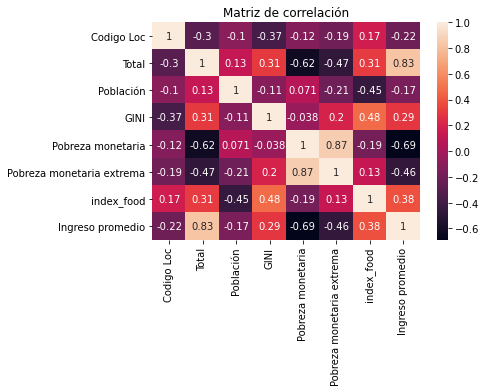

In [41]:
corrMatrix = food_merge.corr()
x = sns.heatmap(corrMatrix, annot=True)
plt.title("Matriz de correlación")
plt.show()
x.figure.savefig('Outputs/corr matrix.png')
